In [20]:
import pandas as pd
import numpy as np
import cv2
import joblib
import mediapipe as mp
import math
from math import cos, sin
import matplotlib.pyplot as plt
import os
import glob
from pathlib import Path
import scipy.io as sio

In [8]:
%%capture
if os.path.isfile('/content/AFLW2000.rar') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

# Generating Data

In [11]:
def get_data_points():
    
    points = []
    
    idx = []
    
    mylist = [Path(f) for f in glob.glob("AFLW2000/*.jpg")]
    
    mp_face_mesh = mp.solutions.face_mesh
    
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode = True)
    
    for pic in mylist:
        img = cv2.imread(str(pic))
        results = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        
        if not results.multi_face_landmarks:
            idx.append(mylist.index(pic))
            continue
        landmarks = results.multi_face_landmarks[0]
        
        for landmark in landmarks.landmark:
            x = landmark.x
            y = landmark.y
            points.append(x)
            points.append(y)
            
    # we have 2000 and 468 point for every pic        
    points = np.array(points).reshape((-1,468*2))
    return pd.DataFrame(points),idx

In [16]:
data , idx = get_data_points()

In [17]:
print(f"Number of truely dicovered pictures are {len(data)}")

Number of truely dicovered pictures are 1853


In [18]:
def get_list_from_filenames(file_path):
    lines=[Path(f).stem for f in glob.glob(file_path)]
    return lines

def get_ypr_from_mat(mat_path):
    # Get yaw, pitch, roll from .mat annotation.
    # They are in radians
    mat = sio.loadmat(mat_path)
    # [pitch yaw roll tdx tdy tdz scale_factor]
    pre_pose_params = mat['Pose_Para'][0]
    # Get [pitch, yaw, roll]
    pose_params = pre_pose_params[:3]
    return pose_params

class AFLW2000():
    def __init__(self, data_dir,file_path, img_ext='.jpg', annot_ext='.mat', image_mode='RGB'):
        self.data_dir = data_dir
        self.file_path = file_path
        self.img_ext = img_ext
        self.annot_ext = annot_ext

        filename_list = get_list_from_filenames(data_dir)
        filename_list.sort()
        self.X_train = filename_list
        self.y_train = filename_list 
        self.image_mode = image_mode
        self.length = len(filename_list)

    def get_labels(self, index):

        mat_path = os.path.join(self.file_path,self.y_train[index] + self.annot_ext)


        # We get the pose in radians
        pose = get_ypr_from_mat(mat_path)
        # And convert to degrees.
        pitch = pose[0] 
        yaw = pose[1] 
        roll = pose[2] 
        # Bin values
        bins = np.array(range(-99, 102, 3))
        labels =np.digitize([yaw, pitch, roll], bins) - 1
        cont_labels = [yaw, pitch, roll]
          
   
        return  cont_labels

In [21]:
demo = AFLW2000("AFLW2000/*.mat",'AFLW2000/')
labels = []

for i in range(2000):
    x = np.array(demo.get_labels(i), dtype=np.float32)
    labels.append(x)
    
labels = np.array(labels, dtype=np.float32)
labels_df=pd.DataFrame(labels,columns=['yaw','pitch','roll'])

In [22]:
final_label = labels_df.drop(idx).reset_index()

In [23]:
final_dataFrame = pd.concat([data,final_label],axis=1)
final_dataFrame.head()

,0,1,2,3,4,5,6,7,8,9,...,930,931,932,933,934,935,index,yaw,pitch,roll
0,0.496543,0.676518,0.490750,0.606071,0.494637,0.629771,0.473451,0.539933,0.489455,0.584179,...,0.528563,0.496846,0.647391,0.470059,0.657674,0.463056,0,0.018227,-0.399231,0.085676
1,0.463354,0.702958,0.420435,0.648624,0.460399,0.659931,0.423678,0.579208,0.413346,0.630818,...,0.502177,0.511878,0.622779,0.476429,0.635914,0.457336,1,1.189533,0.470065,0.300959
2,0.513748,0.702155,0.508066,0.647865,0.509111,0.658546,0.482511,0.566690,0.506144,0.626631,...,0.533205,0.491293,0.657527,0.437964,0.666637,0.430741,2,0.881137,-0.184650,-0.236852
3,0.451924,0.652973,0.441680,0.600616,0.461141,0.618568,0.456288,0.547764,0.442326,0.585527,...,0.526282,0.524878,0.628055,0.536721,0.639166,0.533153,3,0.299208,-0.175379,-0.373374
4,0.430824,0.614294,0.468440,0.544623,0.464932,0.580428,0.509696,0.499168,0.481773,0.527457,...,0.593950,0.527304,0.703736,0.603956,0.721757,0.605597,5,0.011965,-0.026812,-0.220662


In [24]:
final_dataFrame.drop('index',inplace=True,axis=1)
final_dataFrame.to_csv('head_pose.csv',index=False)

# Scale DataFrame

In [9]:
def prep(X):
    
    #get columns that represents X's , Y's 
    x_idx=[str(i) for i in range(X.shape[1]) if i%2==0]
    y_idx=[str(i) for i in range(X.shape[1]) if i%2!=0]
    x_points , y_points = X[x_idx], X[y_idx]
    
    a,b = x_points['8'] , y_points['9']
    
    #center the picture
    x_points = x_points.sub(x_points['10'],axis=0)
    y_points = y_points.sub(y_points['11'],axis=0)

    x_points['8'] , y_points['9'] = a,b
    
    final_df = pd.concat([x_points, y_points], axis=1)
    return final_df

In [25]:
df = pd.read_csv("head_pose.csv")
features = df.drop(columns=['yaw','pitch','roll'],axis=1)
labels = df[['yaw','pitch','roll']]

features_scaled = prep(features)

In [26]:
features_scaled.head()

,0,2,4,6,8,10,12,14,16,18,...,917,919,921,923,925,927,929,931,933,935
0,0.007304,0.001511,0.005398,-0.015787,0.489455,0.0,0.001192,-0.140119,-0.000321,-0.001900,...,0.055617,0.048228,0.063919,0.057491,0.062854,-0.067765,-0.062974,-0.060164,-0.086951,-0.093954
1,0.043707,0.000788,0.040752,0.004031,0.413346,0.0,0.029619,-0.001850,0.033655,0.027234,...,0.049176,0.044020,0.048147,0.051372,0.052948,-0.110445,-0.100557,-0.091318,-0.126768,-0.145860
2,0.010478,0.004796,0.005841,-0.020759,0.506144,0.0,-0.007758,-0.170174,-0.013286,-0.016162,...,0.052703,0.044244,0.042734,0.056863,0.057872,-0.118813,-0.109897,-0.101783,-0.155113,-0.162335
3,-0.000737,-0.010981,0.008480,0.003628,0.442326,0.0,0.035473,-0.008602,0.050164,0.052681,...,0.045718,0.043833,0.059584,0.045737,0.049138,-0.045824,-0.043484,-0.041239,-0.029397,-0.032964
4,-0.072598,-0.034982,-0.038491,0.006274,0.481773,0.0,0.056820,-0.018808,0.095602,0.113236,...,0.059492,0.061422,0.103251,0.056122,0.064229,0.026292,0.019408,0.013057,0.089709,0.091351


## Modeling 

In [31]:
from sklearn.ensemble import RandomForestRegressor
mod_pitch = RandomForestRegressor()
mod_pitch.fit(features_scaled, labels['pitch'])
mod_pitch.score(features_scaled, labels['pitch'])

0.855406910557423

In [32]:
mod_yaw = RandomForestRegressor()
mod_yaw.fit(features_scaled, labels['yaw'])
mod_yaw.score(features_scaled, labels['yaw'])

0.8457660876097426

In [30]:
forest_roll = RandomForestRegressor()
forest_roll.fit(features_scaled, labels['roll'])
forest_roll.score(features_scaled,labels['roll'])

0.8543985343837157

## Making predictions 

In [33]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        shape = img.shape 
        relative_x = int(tdx * shape[1])
        relative_y = int(tdy * shape[0])
        tdx = relative_x
        tdy = relative_y
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2
       

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

In [35]:
dims = []

faceModule = mp.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
  # loading the image
  image = cv2.imread('/content/4.jpg')
  # processing the face to extract the landmark points (468 point) for each x,y,z
  results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  if results.multi_face_landmarks != None: 
    # looping over the faces in the image
    for face in results.multi_face_landmarks:
        for landmark in face.landmark:
            x = landmark.x
            y = landmark.y
            dims.append(x)
            dims.append(y)

In [38]:
bell = pd.DataFrame(dims).T
bell.columns = features.columns
a = prep(bell)

In [39]:
yaw_pred = mod_pitch.predict(a)
pitch_pred = mod_yaw.predict(a)
roll_pred = forest_roll.predict(a)

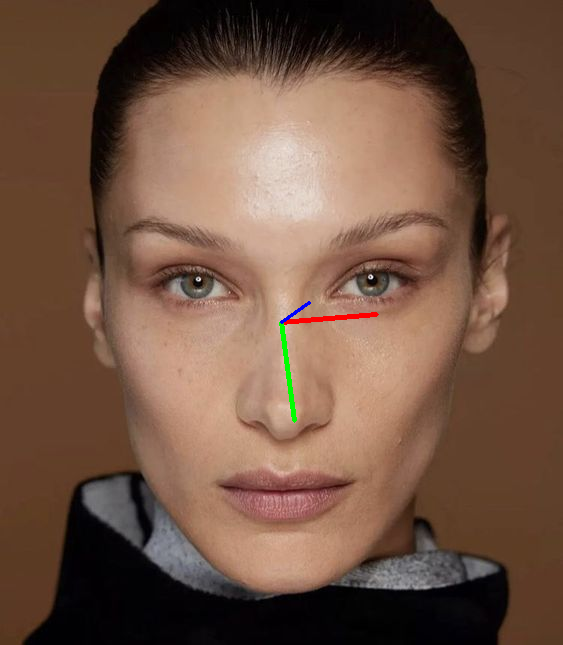

In [41]:
from google.colab.patches import cv2_imshow
cv2_imshow(draw_axis(image, pitch_pred[0], yaw_pred[0],roll_pred[0]))

# Video

In [56]:
def draw_video(path):
    path = '/content/' + path
    cap = cv2.VideoCapture(path)
    # Check if camera opened successfully
    if (cap.isOpened()== False):
        print("Error opening video stream or file")

    #face mesh model
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode = False)
    
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    
    out = cv2.VideoWriter('output.avi',cv2.VideoWriter_fourcc(*'MJPG'), 60, (frame_width,frame_height))
                          
    while (cap.isOpened()):                                          
        ret, frame = cap.read()
        if ret == True:
            #get landmarks
            results = face_mesh.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            #check if we detect any faces
            if not results.multi_face_landmarks:
                print("no face found")
                out.write(frame)
                
            else:
                #get only first face
                face = results.multi_face_landmarks[0]
                dims = []
                
                for landmark in face.landmark:
                  x = landmark.x
                  y = landmark.y
                  dims.append(x)
                  dims.append(y)
                
                feautres_df = pd.DataFrame(dims).T  
                feautres_df.columns = features.columns
                feautres_df = prep(feautres_df)
                
                nframe = draw_axis(frame, mod_pitch.predict(feautres_df)[0], mod_yaw.predict(feautres_df)[0], forest_roll.predict(feautres_df)[0], tdx = feautres_df[10][0], tdy = feautres_df[11][0])

                out.write(nframe)
                
            
            if cv2.waitKey(25) & 0xFF == ord('q'):
                  break         
        else:
            break 
    out.release()
    cap.release()
    cv2.destroyAllWindows()
    return

In [57]:
draw_video('/content/WIN_20220617_15_55_02_Pro.mp4')

Error opening video stream or file
